In [1]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


import sys
import os
sys.path.append(os.path.abspath("../../.."))

from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns 

from Preprocessing.imputation import get_imputation_maps, apply_imputation, ContextImputer
from Preprocessing.split_new import split_data
from Preprocessing.get_all_data import get_full_data
from utils.eval_call import evaluate_model
from utils.scatter_plot import scatter_prediction


In [12]:

X_train, X_test, y_train, y_test, categorical_features , numeric_features = split_data('../../../data.csv')

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

transformed_model = TransformedTargetRegressor(
    regressor=LinearRegression(),
    func=np.log1p,
    inverse_func=np.expm1
)

pipeline = Pipeline(steps=[
    ('imp_fc', ContextImputer('fuel_consumption_l_100km')),
    ('imp_ps', ContextImputer('power_ps')),
    ('imp_er', ContextImputer('electric_range')),
    ('preprocessor', preprocessor),
    ('model', transformed_model)
])

# Cross Validation – KFold mit Shuffle und Seed
kf = KFold(n_splits= 10, shuffle=True, random_state=42)
y_pred = cross_val_predict(pipeline, X_train, y_train, cv=kf)

# Evaluation
print('Cross Validation Training:')
print("MAE:", round(mean_absolute_error(y_train, y_pred),2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_train, y_pred)),2))
print("R²:", round(r2_score(y_train, y_pred),2))

    # Modell trainieren
pipeline.fit(X_train, y_train)

# Vorhersagen treffen
y_pred_lr = pipeline.predict(X_test)

evaluate_model(y_test, y_pred_lr, "Linear Regression")


Cross Validation Training:
MAE: 3837.84
RMSE: 14748.07
R²: 0.82
Linear Regression Performance Metrics:
MAE: 4070.77
MSE: 1056484080.30
RMSE: 32503.60
R²: 0.49
------------------------------


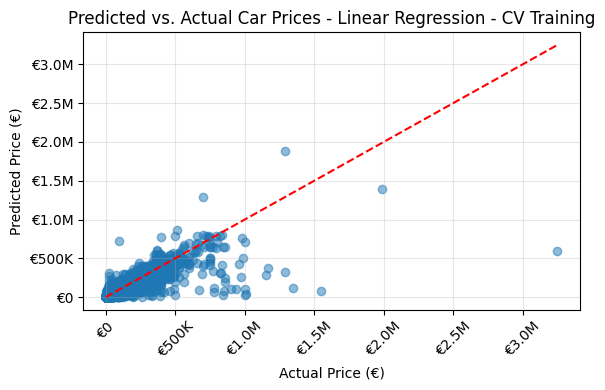

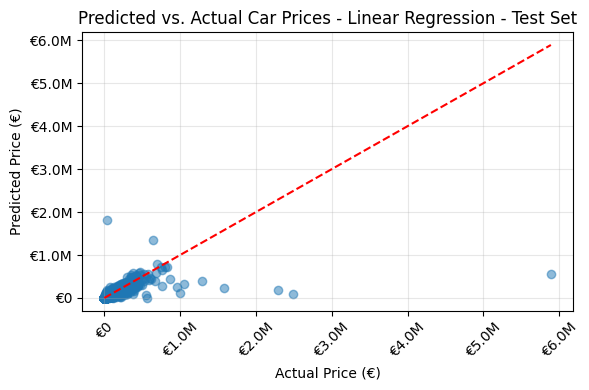

In [13]:
scatter_prediction(y_train, y_pred, "Linear Regression - CV Training")
scatter_prediction(y_test, y_pred_lr, "Linear Regression - Test Set")